In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


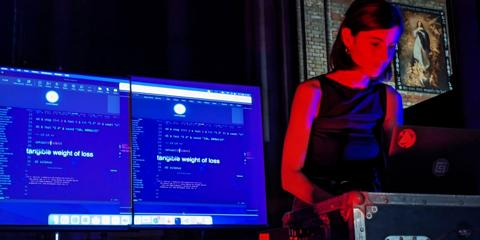

[How AI can help supercharge creativity](https://www.technologyreview.com/2025/04/10/1114256/ai-creativity-art-collaboration-music/) - MIT Technology Review

___

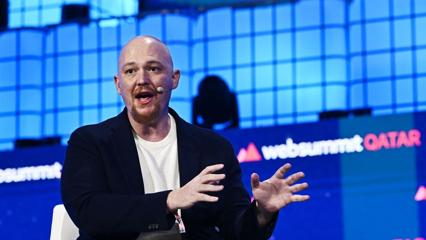

[Replit CEO Amjad Masad says AGI won't replace humans — unless you're a "code monkey" who just cuts and pastes from Stack Overflow. Most programmers are better than that, right? Right?](https://www.windowscentral.com/software-apps/work-productivity/replit-ceo-ai-wont-replace-code-monkeys) - Windows Central

___

[AI asseses health of cherry trees](https://phys.org/news/2025-04-ai-tool-aims-japan-cherry.html)

___

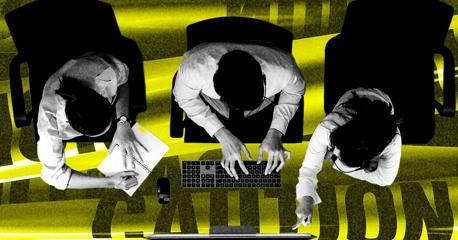

[Zico Kolter, a Carnegie Mellon professor and board member at OpenAI, on the dangers of AI agents interacting autonomously, highlighting the need for models to be more resistant to attacks and secure against vulnerabilities like jailbreaks and malicious exploitation.](https://www.wired.com/story/zico-kolter-ai-agents-game-theory/) - WIRED

___

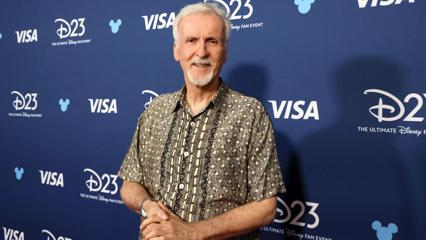

[James Cameron, in a podcast with Meta's Andrew Bosworth, expressed cautious optimism about generative AI's potential to reduce the cost of VFX-intensive films by accelerating workflows, advocating for a focus on regulating AI outputs rather than training inputs.](https://www.hollywoodreporter.com/business/business-news/james-cameron-generative-ai-filmmaking-text-prompts-1236186102/) - The Hollywood Reporter

___

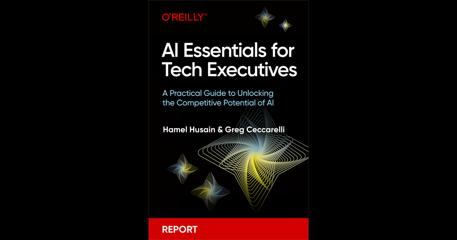

[AI Essentials for Tech Executives book from O'Reilly](https://www.oreilly.com/library/view/ai-essentials-for/9798341622463/) - O’Reilly Online Learning

___

[Inside Google's Isomorphic Labs, the secretive AI life sciences startup](https://www.cnbc.com/2025/04/09/inside-isomorphic-labs-google-deepminds-ai-life-sciences-spinoff.html)

___

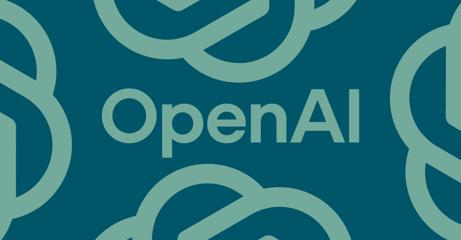

[OpenAI requests court enjoin and hold Musk accountable for bad faith attacks animated by a personal vendetta.](https://www.theverge.com/news/646308/openai-countersues-elon-musk) - The Verge

___

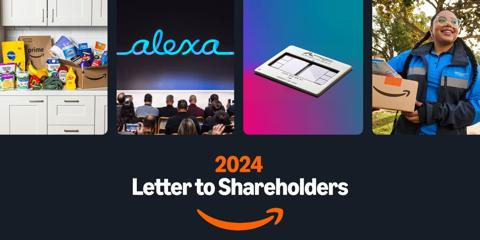

[Andy Jassy: Generative AI is going to reinvent virtually every customer experience we know, and enable altogether new ones about which we’ve only fantasized.](https://www.aboutamazon.com/news/company-news/amazon-ceo-andy-jassy-2024-letter-to-shareholders)

___

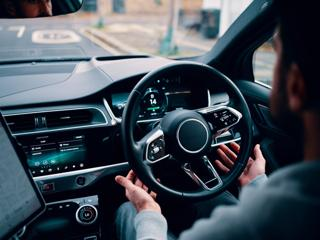

[Nissan partners with Wayve for self-driving tech](https://techcrunch.com/2025/04/09/wayves-self-driving-tech-is-headed-to-nissan-vehicles/) - TechCrunch

___

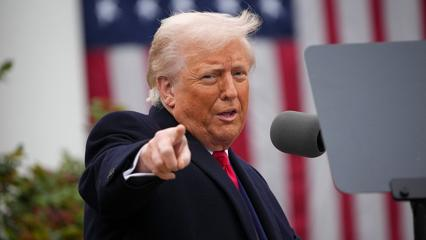

[Not sure you can legally or morally exempt a person or company from a tax or a law because they are your buddy but  Jeff Yass and TikTok says otherwise](https://www.foxnews.com/politics/trump-says-hell-take-look-exempting-some-larger-us-companies-hit-especially-hard-tariffs) - Fox News

___

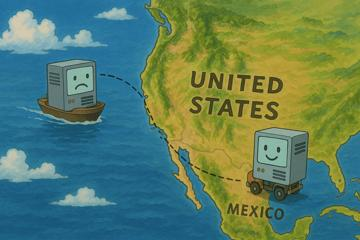

[Tariff Armageddon raises prices of GPUs, and everything. Maybe just build data centers across the border in Mexico or Canada](https://semianalysis.com/2025/04/10/tariff-armageddon-gpu-loopholes/) - SemiAnalysis

___

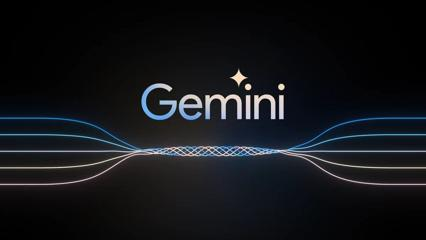

[Google enhances Workspace AI integrations with office productivity apps](https://www.techradar.com/computing/artificial-intelligence/i-tried-using-these-5-google-apps-with-gemini-and-now-i-use-them-with-ai-all-the-time) - TechRadar

___

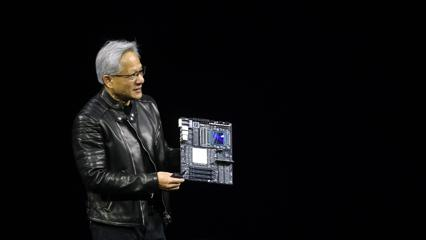

[Trump administration backs off Nvidia's 'H20' chip crackdown after Mar-a-Lago dinner](https://www.npr.org/2025/04/09/nx-s1-5356480/nvidia-china-ai-h20-chips-trump) - NPR

___

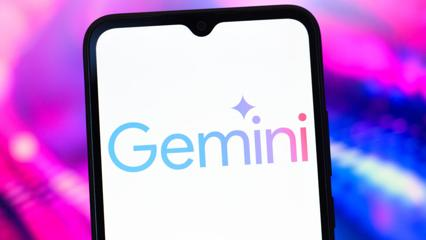

[Google announces faster, more efficient Gemini 2.5 Flash model](https://arstechnica.com/ai/2025/04/googles-best-gemini-ai-model-is-showing-up-in-more-places/) - Ars Technica

___

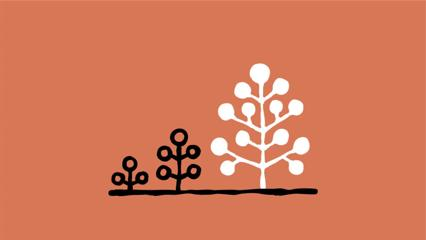

[Anthropic announces a higher tier with fewer rate limits](https://arstechnica.com/ai/2025/04/anthropic-launches-200-claude-max-ai-plan-with-20x-higher-usage-limits/) - Ars Technica

___

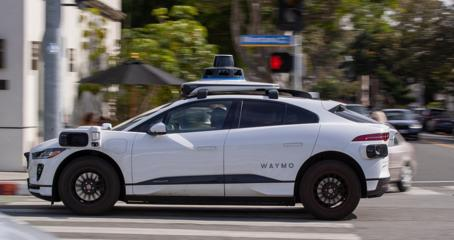

[A Waymo robotaxi trapped itself in a Chick-fil-A drive-through](https://techcrunch.com/2025/04/09/a-waymo-robotaxi-got-trapped-in-chick-fil-a-drive-through/) - TechCrunch

___

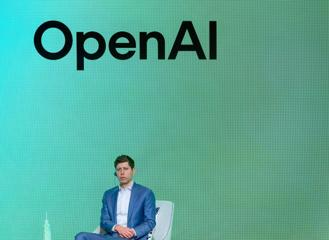

[OpenAI asks court to enjoin Musk from supervillain shenanigans](https://techcrunch.com/2025/04/09/openai-attorneys-call-for-musk-to-be-enjoined-from-further-unlawful-and-unfair-action/) - TechCrunch

___

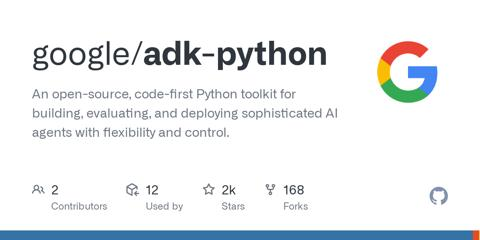

[Google releases agent SDK](https://github.com/google/adk-python) - GitHub

___

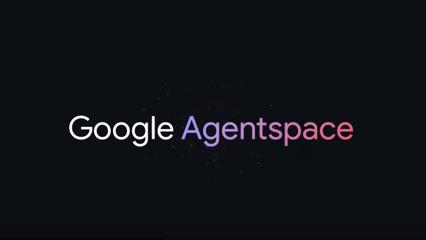

[Google launches Agent2Agent protocol to connect AI agents](https://www.testingcatalog.com/google-launches-agent2agent-protocol-to-connect-ai-agents-across-platforms/) - TestingCatalog

___

absolute pudding for brains

Wall Street big sad
Who knew fascism could be so bad

In [ ]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [ ]:
print(datetime.now())

In [ ]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

In [ ]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


In [ ]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [ ]:
a

In [ ]:
b



In [ ]:
```mermaid
flowchart LR

A[Hard] -->|Text| B(Round)
B --> C{Decision}
C -->|One| D[Result 1]
C -->|Two| E[Result 2]
